In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from IPython.display import SVG

## Load data and prediction

In [2]:
BASE = '../data/'
ignore_chiral = False

data = pd.read_csv('../data/real/acs.csv')
pred = pd.read_csv('../output/uspto/swin_base_char_aux_1m680k/prediction_acs.csv')

## Display the error cases

--------------------
2
real/acs/3.png
gold: *NC(=O)CCC(=O)N*
post: *N(C)C(=O)CCC(=O)N(*)C
grph: *N(C)C(=O)CCC(=O)N(*)C
pred: CN([R])C(CCC(N([R])C)=O)=O
(643, 1125, 3)


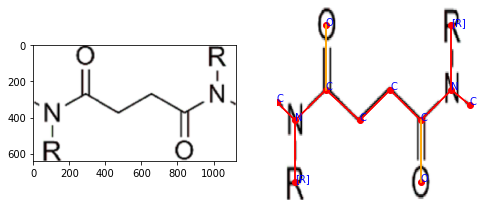

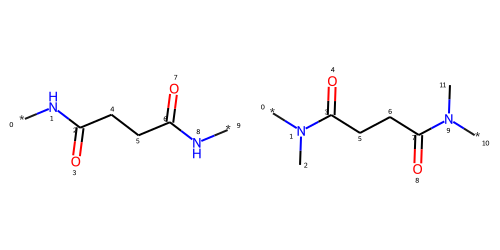

--------------------
4
real/acs/5.png
gold: [2*]c1cc(C)[p-]c1[2*]
post: [2*]c1cc(C)[pH]c1[2*]
grph: [2*]c1cc(C)[pH]c1[2*]
pred: CC1PC([R2])=C([R2])C=1
(785, 977, 3)


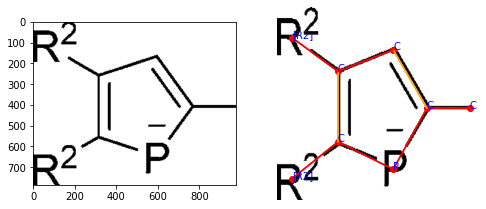

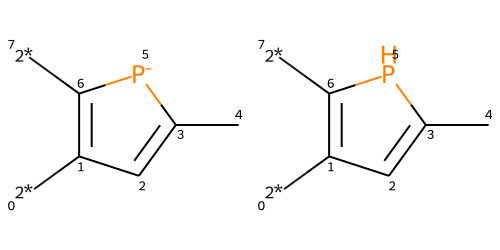

In [3]:
from molscribe.chemistry import _postprocess_smiles, _convert_graph_to_smiles
from molscribe.evaluate import canonicalize_smiles
from molscribe.augment import CropWhite
import albumentations as A
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600,600

transform = A.Compose([CropWhite(pad=0), A.Resize(384,384)])

cnt = 0 
for idx, row in data.iterrows():
    gold_smiles,_ = canonicalize_smiles(row['SMILES'], ignore_cistrans=True, ignore_chiral=ignore_chiral)
    pred_smiles = pred.loc[idx,'SMILES']
    post_smiles,_ = canonicalize_smiles(pred.loc[idx,'post_SMILES'], ignore_cistrans=True, ignore_chiral=ignore_chiral)
    graph_smiles,_ = canonicalize_smiles(pred.loc[idx,'graph_SMILES'], ignore_cistrans=True, ignore_chiral=ignore_chiral)
    if gold_smiles == post_smiles:
        continue
    print('-' * 20)
    cnt += 1
    print(idx)
    print(row['file_path'])
    print('gold:', gold_smiles)
    print('post:', post_smiles)
    print('grph:', graph_smiles)
    print('pred:', pred_smiles)
    file = str(row['file_path'])
    path = BASE + file
    image = cv2.imread(path)
    print(image.shape)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.axis('off')
    img = transform(image=image)['image']
    plt.imshow(img)
    if 'node_coords' in pred.columns:
        coords = np.array(eval(pred.loc[idx, 'node_coords']))
        symbols = eval(pred.loc[idx, 'node_symbols'])
        edges = eval(pred.loc[idx, 'edges'])
        h, w, _ = img.shape
        x, y = coords[:,0]*w, coords[:,1]*h
        plt.scatter(x, y, color='r', marker='o')
        for i in range(len(symbols)):
            plt.text(x[i], y[i], symbols[i], color='blue')
        for i in range(len(x)):
            for j in range(len(x)):
                if edges[i][j] != 0:
                    if edges[i][j] in [5, 6]:
                        color = 'blue' if edges[i][j] == 5 else 'green'
                        plt.arrow(x[i], y[i], x[j]-x[i], y[j]-y[i], color=color, head_width=20)
                    else:
                        color = 'red' if edges[i][j] == 1 else 'orange'
                        plt.plot([x[i], x[j]], [y[i], y[j]], color)
    plt.show()
    mol1 = Chem.MolFromSmiles(gold_smiles)
    mol2 = Chem.MolFromSmiles(post_smiles)
    svg = Draw.MolsToGridImage([mol1, mol2], subImgSize=(250,250), molsPerRow=2, useSVG=True)
    display(svg)
    if cnt == 2:
        break

## Analyze a single example

real/acs/op300128c-Scheme-c9-1.png


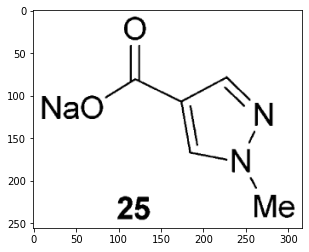

Gold: Cn1cc(C(=O)O[Na])cn1
Pred: [NaO]C(=O)C1C=NN([Me])C=1
Post: Cn1cc(C(=O)O[Na])cn1


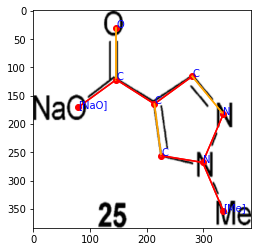

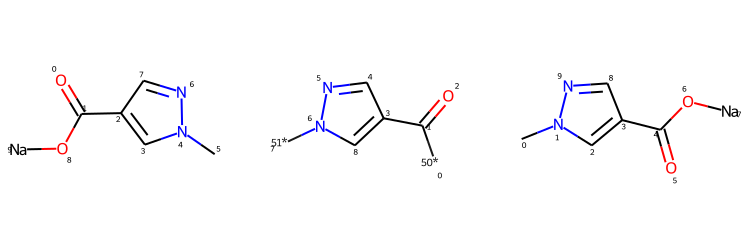

[]
[[0.206, 0.444], [0.381, 0.317], [0.381, 0.079], [0.556, 0.429], [0.73, 0.302], [0.873, 0.476], [0.778, 0.698], [0.873, 0.921], [0.587, 0.667]]
['[NaO]', 'C', 'O', 'C', 'C', 'N', 'N', '[Me]', 'C']
[[0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 1, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 2], [0, 0, 0, 1, 0, 2, 0, 0, 0], [0, 0, 0, 0, 2, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 2, 0, 0, 1, 0, 0]]
[NaO]C(=O)C1C=NN([Me])C=1
post: Cn1cc(C(=O)O[Na])cn1
graph: Cn1cc(C(=O)O[Na])cn1


In [4]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300
from molscribe.chemistry import _postprocess_smiles, _replace_functional_group, _convert_graph_to_smiles
from molscribe.evaluate import canonicalize_smiles
from molscribe.augment import CropWhite
import albumentations as A

i = 136
gold_smiles = data.loc[i, 'SMILES']
if gold_smiles is None or type(gold_smiles) is not str:
    gold_smiles = ''
print(data.loc[i, 'file_path'])
path = BASE + data.loc[i, 'file_path']
img = cv2.imread(path)
plt.imshow(img)
plt.show()
transform = A.Compose([CropWhite(pad=0), A.Resize(384,384)])
img = transform(image=img)['image']

pred_row = pred.loc[i]
pred_smiles = pred_row['SMILES']
post_smiles = pred_row['post_SMILES']

print('Gold:', canonicalize_smiles(gold_smiles)[0])
print('Pred:', pred_smiles)
print('Post:', post_smiles)

coords = eval(pred_row['node_coords'])
symbols = eval(pred_row['node_symbols'])
edges = eval(pred_row['edges'])

plt.imshow(img)
h,w,_ = img.shape
x, y = np.array(coords)[:,0]*w, np.array(coords)[:,1]*h
plt.scatter(x, y, color='r', marker='o')
for i in range(len(symbols)):
    plt.text(x[i], y[i], symbols[i], color='blue')
for i in range(len(x)):
    for j in range(len(x)):
        if edges[i][j] != 0:
            if edges[i][j] in [5, 6]:
                color = 'blue' if edges[i][j] == 5 else 'green'
                plt.arrow(x[i], y[i], x[j]-x[i], y[j]-y[i], color=color, head_width=20)
            else:
                if edges[i][j] == 1:
                    color = 'red'
                elif edges[i][j] == 2:
                    color = 'orange'
                else:
                    color = 'yellow'
                plt.plot([x[i], x[j]], [y[i], y[j]], color)
plt.show()

mol_gold = Chem.MolFromSmiles(gold_smiles)
pred_smiles = pred_smiles.replace('@', '')
pred_smiles, mappings = _replace_functional_group(pred_smiles)
mol_pred = Chem.MolFromSmiles(pred_smiles)
mol_post = Chem.MolFromSmiles(post_smiles)
img = Chem.Draw.MolsToGridImage([mol_gold,mol_pred,mol_post], subImgSize=(250,250), molsPerRow=3, useSVG=True)
display(img)
if mol_pred is not None:
    chiral_centers = Chem.FindMolChiralCenters(mol_pred, includeUnassigned=True, includeCIP=False, useLegacyImplementation=False)
    print(chiral_centers)

print(coords)
print(symbols)
print(edges)

pred_smiles = pred_row['SMILES']
print(pred_smiles, flush=True)
smiles, *_ = _postprocess_smiles(pred_smiles, coords, symbols, edges, molblock=True, debug=True)
print('post:', smiles)

smiles, *_ = _convert_graph_to_smiles(coords, symbols, edges, debug=True)
print('graph:', smiles)